<a href="https://colab.research.google.com/github/aravindchakravarti/Deep_Learning_EVA_4/blob/master/S7_Cifar/S7_Cifar_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import required libraries

In [0]:
from __future__ import print_function
import torch
# Import core module
import torch.nn as nn
# We need support for functional programming
import torch.nn.functional as F
import torch.optim as optim
# For MNIST dataset
from torchvision import datasets, transforms
# For Global Average Pooling
from torch.nn import AvgPool2d
# Plotting purpose
%matplotlib inline
import matplotlib.pyplot as plt
# Import Torch Vision
import torchvision
# Import math library! The Numpy
import numpy as np

# Dataset Loading and Initializing the trasnforms

## Create a tranform function which is required further for the train and test loader


In [0]:
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                      #  transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.RandomAffine(degrees=10, shear = 10),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

## Dataset download to the environment

In [3]:
train = datasets.CIFAR10(root = './data', train=True, download=True, transform=train_transforms)
test = datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transforms)

Files already downloaded and verified
Files already downloaded and verified


## Dataloaders
We have downloaded the dataset and defined some function for the image transforms (which includes the image augmentation as well). 

Below steps ensure that we use GPU for our training and testing (Basically we want the data to be in the GPU for getting best performance) 

In [4]:
# Do we have CUDA drivers for us?
cuda = torch.cuda.is_available()
print ("Cuda Available?", cuda)

dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# Dataloaders
train_loader = torch.utils.data.DataLoader(dataset=train, **dataloader_args)
test_loader = torch.utils.data.DataLoader(dataset=test, **dataloader_args)

Cuda Available? True


## Number of classes
I am not sure if is specific to CIFAR-10. Lets see afterwards

In [0]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

## Data visualization

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


  car  frog truck plane


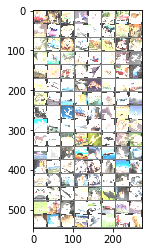

In [6]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

# The Convolutional Neural Network Model 

## The skeleton of the network

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv01 = nn.Conv2d(3, 16, 3, bias=False, padding=1)        #O=32
        self.batch01 = nn.BatchNorm2d(num_features=16)    
        self.conv02 = nn.Conv2d(16, 16, 3, bias=False,padding=1)        #O=28
        self.batch02 = nn.BatchNorm2d(num_features=16)    
        self.conv03 = nn.Conv2d(16, 16, 3, bias=False,padding=1)        #O=28
        self.batch03 = nn.BatchNorm2d(num_features=16)   
        self.conv04 = nn.Conv2d(16, 16, 3, bias=False,padding=1)        #O=26
        self.batch04 = nn.BatchNorm2d(num_features=16)   
        self.pool01 = nn.MaxPool2d(2, 2)                                #O=16
        self.conv05 = nn.Conv2d(16, 16, 1, bias=False)

        self.conv11 = nn.Conv2d(16, 32, 3, bias=False, padding=1)       #O=
        self.batch11 = nn.BatchNorm2d(num_features=32)
        self.conv12 = nn.Conv2d(32, 32, 3, bias=False, padding=1)       #O=
        self.batch12 = nn.BatchNorm2d(num_features=32)
        self.conv13 = nn.Conv2d(32, 32, 3, bias=False, padding=1)       #O=
        self.batch13 = nn.BatchNorm2d(num_features=32)
        self.conv14 = nn.Conv2d(32, 32, 3, bias=False, padding=1)       #O=
        self.batch14 = nn.BatchNorm2d(num_features=32)
        self.pool11 = nn.MaxPool2d(2, 2)                                #O=8
        self.conv15 = nn.Conv2d(32, 32, 1, bias=False)

        self.conv21 = nn.Conv2d(32, 64, 3, bias=False, padding=1)       #O=
        self.batch21 = nn.BatchNorm2d(num_features=64)
        self.conv22 = nn.Conv2d(64, 64, 3, bias=False, padding=1)       #O=
        self.batch22 = nn.BatchNorm2d(num_features=64)
        self.conv23 = nn.Conv2d(64, 64, 3, bias=False, padding=1)       #O=
        self.batch23 = nn.BatchNorm2d(num_features=64)
        self.conv24 = nn.Conv2d(64, 64, 3, bias=False, padding=1)       #O=
        self.batch24 = nn.BatchNorm2d(num_features=64)
        self.pool21 = nn.MaxPool2d(2, 2)                                #O=4
        self.conv25 = nn.Conv2d(64, 32, 1, bias=False)

        self.conv31 = nn.Conv2d(32, 64, 3, bias=False, padding=1)       #O=05
        self.batch31 = nn.BatchNorm2d(num_features=64)
        self.conv32 = nn.Conv2d(64, 64, 3, bias=False, padding=1)       #O=05
        self.batch32 = nn.BatchNorm2d(num_features=64)
        self.conv33 = nn.Conv2d(64, 64, 3, bias=False, padding=1)       #O=05
        self.batch33 = nn.BatchNorm2d(num_features=64)
    
        self.avg_pool = nn.AvgPool2d(kernel_size=4)
        self.convx3 = nn.Conv2d(64, 10, 1, bias=False, padding=0)

    def forward(self, x):
        x = self.batch01(F.relu(self.conv01(x)))        
        x = self.batch02(F.relu(self.conv02(x)))
        x = self.batch03(F.relu(self.conv03(x)))
        x = self.batch04(F.relu(self.conv04(x)))
        x = self.pool01(x)
        x = self.conv05(x)

        x = self.batch11(F.relu(self.conv11(x)))
        x = self.batch12(F.relu(self.conv12(x)))
        x = self.batch13(F.relu(self.conv13(x)))
        x = self.batch14(F.relu(self.conv14(x)))
        x = self.pool11(x)
        x = self.conv15(x)

        x = self.batch21(F.relu(self.conv21(x)))
        x = self.batch22(F.relu(self.conv22(x)))
        x = self.batch23(F.relu(self.conv23(x)))
        x = self.batch24(F.relu(self.conv24(x)))
        x = self.pool21(x)
        x = self.conv25(x)

        x = self.batch31(F.relu(self.conv31(x)))
        x = self.batch32(F.relu(self.conv32(x)))
        x = self.batch33(F.relu(self.conv33(x)))


        x = self.avg_pool(x)
        x = self.convx3(x)
        x = x.view(-1, 10)                           # Don't want 10x1x1..
        return F.log_softmax(x)

## Display model summary

In [23]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
       BatchNorm2d-2           [-1, 16, 32, 32]              32
            Conv2d-3           [-1, 16, 32, 32]           2,304
       BatchNorm2d-4           [-1, 16, 32, 32]              32
            Conv2d-5           [-1, 16, 32, 32]           2,304
       BatchNorm2d-6           [-1, 16, 32, 32]              32
            Conv2d-7           [-1, 16, 32, 32]           2,304
       BatchNorm2d-8           [-1, 16, 32, 32]              32
         MaxPool2d-9           [-1, 16, 16, 16]               0
           Conv2d-10           [-1, 16, 16, 16]             256
           Conv2d-11           [-1, 32, 16, 16]           4,608
      BatchNorm2d-12           [-1, 32, 16, 16]              64
           Conv2d-13           [-1, 32, 16, 16]           9,216
      BatchNorm2d-14           [-1, 32,

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


# Training and Testing

## Setup Train and Test functions

In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)

  correct = 0
  processed = 0

  for batch_idx, (data, target) in enumerate (pbar):
    data, target = data.to(device), target.to(device)

    #Don't want history of gradients 
    optimizer.zero_grad()

    y_predict = model(data)

    # Caluclate loss
    loss = F.nll_loss(y_predict, target)
    train_losses.append(loss)

    # Back propogate error
    loss.backward()

    # Take a optimzer step
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_predict.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)


def test (model, device, test_loader):
  model.eval()

  test_loss = 0
  correct = 0

  with torch.no_grad():
    for data, target in test_loader:
      data, target = data.to(device), target.to(device)

      output = model(data)

      test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
      pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
      correct += pred.eq(target.view_as(pred)).sum().item()

  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)

  print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))
    
  test_acc.append(100. * correct / len(test_loader.dataset))

## Setup Optimizers

In [0]:
model =  Net().to(device)
criteria = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = 0.01, momentum=0.9)

In [0]:
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    # scheduler.step()
    test(model, device, test_loader)

  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH: 0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
Loss=1.235370397567749 Batch_id=390 Accuracy=42.61: 100%|██████████| 391/391 [00:28<00:00, 13.71it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 1.3115, Accuracy: 5298/10000 (52.98%)

EPOCH: 1


Loss=1.077358603477478 Batch_id=390 Accuracy=59.51: 100%|██████████| 391/391 [00:28<00:00, 13.74it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 1.0360, Accuracy: 6318/10000 (63.18%)

EPOCH: 2


Loss=0.9948863983154297 Batch_id=390 Accuracy=67.16: 100%|██████████| 391/391 [00:28<00:00, 13.82it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.8849, Accuracy: 6916/10000 (69.16%)

EPOCH: 3


Loss=0.7258342504501343 Batch_id=390 Accuracy=71.42: 100%|██████████| 391/391 [00:28<00:00, 13.79it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.8055, Accuracy: 7192/10000 (71.92%)

EPOCH: 4


Loss=0.758222758769989 Batch_id=390 Accuracy=74.09: 100%|██████████| 391/391 [00:28<00:00, 13.81it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.7277, Accuracy: 7450/10000 (74.50%)

EPOCH: 5


Loss=0.6225559115409851 Batch_id=390 Accuracy=76.51: 100%|██████████| 391/391 [00:28<00:00, 13.79it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.7286, Accuracy: 7507/10000 (75.07%)

EPOCH: 6


Loss=0.701285183429718 Batch_id=390 Accuracy=78.12: 100%|██████████| 391/391 [00:28<00:00, 13.73it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.6331, Accuracy: 7820/10000 (78.20%)

EPOCH: 7


Loss=0.6207834482192993 Batch_id=390 Accuracy=79.49: 100%|██████████| 391/391 [00:28<00:00, 13.81it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.6164, Accuracy: 7877/10000 (78.77%)

EPOCH: 8


Loss=0.7152092456817627 Batch_id=390 Accuracy=80.56: 100%|██████████| 391/391 [00:28<00:00, 13.75it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.6130, Accuracy: 7900/10000 (79.00%)

EPOCH: 9


Loss=0.47102564573287964 Batch_id=390 Accuracy=81.37: 100%|██████████| 391/391 [00:28<00:00, 13.83it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5980, Accuracy: 7971/10000 (79.71%)

EPOCH: 10


Loss=0.42321377992630005 Batch_id=390 Accuracy=82.09: 100%|██████████| 391/391 [00:28<00:00, 13.71it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5737, Accuracy: 8063/10000 (80.63%)

EPOCH: 11


Loss=0.456556499004364 Batch_id=390 Accuracy=83.10: 100%|██████████| 391/391 [00:28<00:00, 13.82it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5737, Accuracy: 8041/10000 (80.41%)

EPOCH: 12


Loss=0.47500813007354736 Batch_id=340 Accuracy=84.03:  87%|████████▋ | 341/391 [00:24<00:03, 13.89it/s]